/tmp/ipykernel_18994/2804384722.py:48: DeprecationWarning:

Specifying min_anomaly and max_anomaly in method `sample` is deprecated and will be removed in a future release, use `Orbit.to_ephem(strategy=TrueAnomalyBounds(min_nu=..., max_nu=...))` instead

/tmp/ipykernel_18994/2804384722.py:70: DeprecationWarning:

Specifying min_anomaly and max_anomaly in method `sample` is deprecated and will be removed in a future release, use `Orbit.to_ephem(strategy=TrueAnomalyBounds(min_nu=..., max_nu=...))` instead



Initial impulse: (<Quantity 0. s>, <Quantity [886.93797004, 568.13322972, 247.37221072] m / s>)
Final impulse: (<Quantity 34658187.19869173 s>, <Quantity [-10545.24842414,  -5813.72343976,  -2518.61652123] m / s>)
Initial impulse: (<Quantity 0. s>, <Quantity [-7721.07635581,  2075.30250271,  3695.17037263] m / s>)
Final impulse: (<Quantity 86342221.00159356 s>, <Quantity [   14.32045511, -5178.0801084 , -1696.54538318] m / s>)


/tmp/ipykernel_18994/2804384722.py:93: DeprecationWarning:

Specifying min_anomaly and max_anomaly in method `sample` is deprecated and will be removed in a future release, use `Orbit.to_ephem(strategy=TrueAnomalyBounds(min_nu=..., max_nu=...))` instead



([<matplotlib.collections.LineCollection at 0x7f720f9e5ed0>],
 <matplotlib.lines.Line2D at 0x7f720faee2c0>)

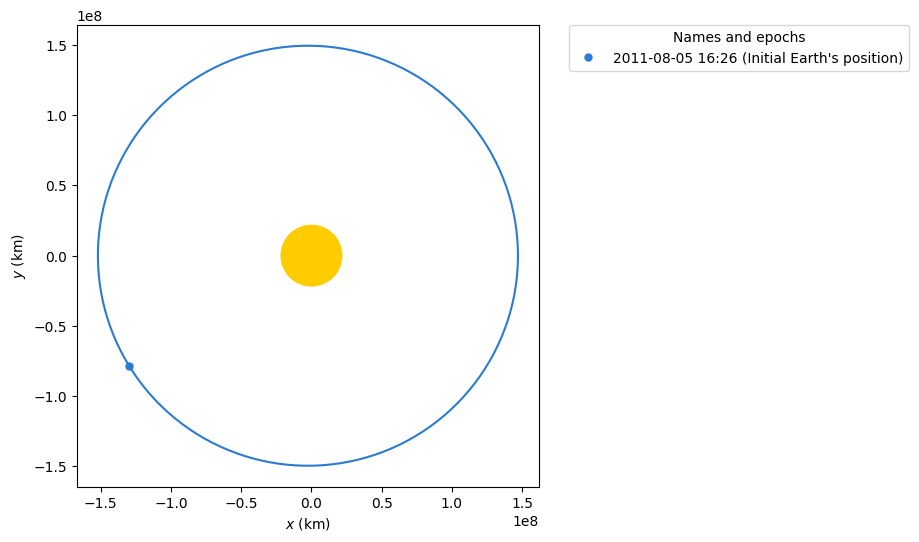

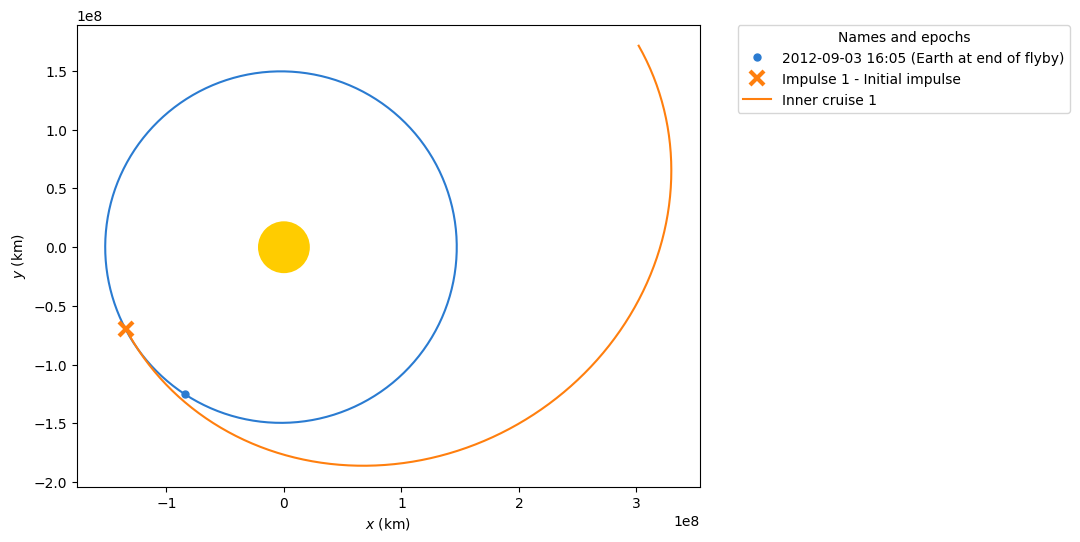

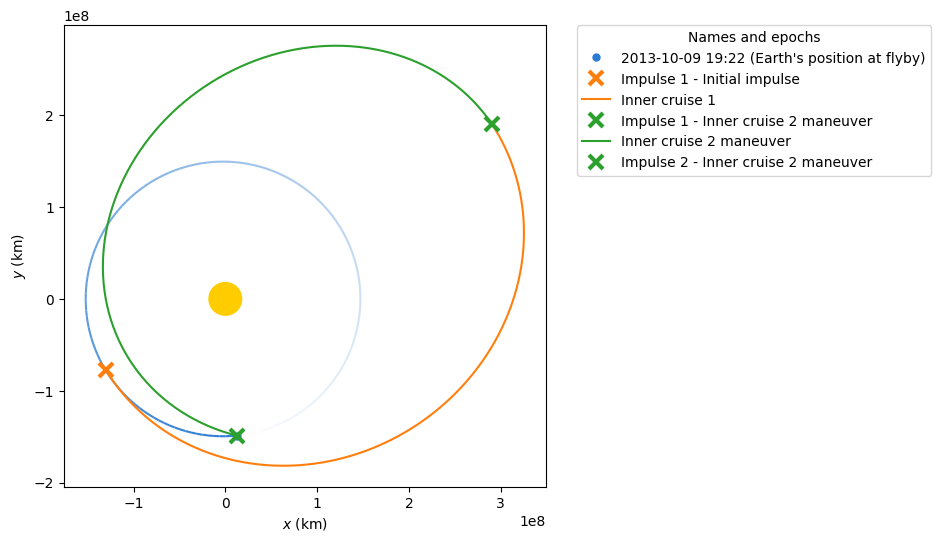

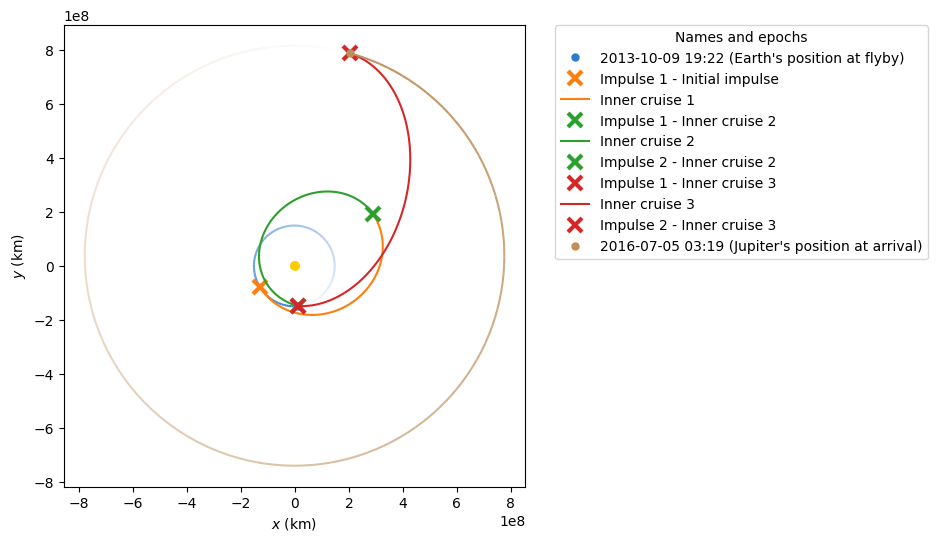

In [38]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

import numpy as np

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range

## Main dates
date_launch = Time("2011-08-05 16:25", scale="utc").tdb
date_flyby = Time("2013-10-09 19:21", scale="utc").tdb
date_arrival = Time("2016-07-05 03:18", scale="utc").tdb

# Atlas V supplied a launch energy
C_3 = 31.1 * u.km**2 / u.s**2

# Plot initial Earth's position
Earth.plot(date_launch, label="Initial Earth's position")

earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival, periods=500))
r_e0, v_e0 = earth.rv(date_launch)

# Assume that the insertion velocity is tangential to that of the Earth
dv = C_3**0.5 * v_e0 / norm(v_e0)

# We create the maneuver from impulse constructor
man = Maneuver.impulse(dv)

ss_e0 = Orbit.from_ephem(Sun, earth, date_launch)
ss_efly = Orbit.from_ephem(Sun, earth, date_flyby)

# Inner Cruise 1
ic1 = ss_e0.apply_maneuver(man)
ic1_end = ic1.propagate_to_anomaly(180.0 * u.deg)

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth, ic1_end.epoch, label="Earth at end of flyby")
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(ic1.sample(max_anomaly=180 * u.deg),label="Inner cruise 1",color="C1",)
ic1.period.to(u.day)

# Let's compute the Lambert solution to do the flyby of the Earth
man_flyby = Maneuver.lambert(ic1_end, ss_efly)
imp_a, imp_b = man_flyby.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)
# Check the initial delta-V
dv_a = imp_a[-1]
norm(dv_a.to(u.km / u.s))

# Let us apply the maneuver
ic2, ss_flyby = ic1_end.apply_maneuver(man_flyby, intermediate=True)

# We propagate the transfer orbit till the flyby occurs
ic2_end = ic2.propagate(date_flyby)

plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(   Earth,    ss_efly.epoch,    label="Earth's position at flyby",    trail=True,)
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(    ic1.sample(max_anomaly=180 * u.deg), label="Inner cruise 1", color="C1")
plotter.plot_maneuver(    ic1_end,    man_flyby,    label="Inner cruise 2 maneuver",    color="C2",)

# And now, go to Jupiter!
jupiter = Ephem.from_body(Jupiter, time_range(date_launch, end=date_arrival))

ss_j = Orbit.from_ephem(Sun, jupiter, date_arrival)

# Solving for maneuver to Jupiter
man_jupiter = Maneuver.lambert(ic2_end, ss_j)
imp_a, imp_b = man_jupiter.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)

# Apply the maneuver
ic3, ss_target = ic2_end.apply_maneuver(man_jupiter, intermediate=True)
ic3_end = ic3.propagate(date_arrival)

# Final plot for the whole mission
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(    Earth,    date_flyby,    label="Earth's position at flyby",    trail=True,)
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(    ic1.sample(max_anomaly=180 * u.deg), label="Inner cruise 1", color="C1")
plotter.plot_maneuver(    ic1_end,    man_flyby,    label="Inner cruise 2",    color="C2",)
plotter.plot_maneuver(    ic2_end,    man_jupiter,    label="Inner cruise 3",    color="C3",)
plotter.plot_body_orbit(    Jupiter, date_arrival, label="Jupiter's position at arrival", trail=True)